# Optimization Techniques in Machine Learning


## Case Study and Implementation




## The Dataset
> ***Brief Description:***
The problem I am trying to solve is poaching in animal habitats which are so unbelievably large that they become almost impossible to fully monitor for the guards there, making it easy for poachers to attack animals without being scared of being caught. To solve this I plan on building an alerting system that listens to audio, makes a prediction using my models and then sends an alert to wildlife rangers when human activity is heard, so they can get there in time to stop them or arrest them. 
 I used a dataset of 2000 audio files of environmental sounds that could occur in those such habitats, the sounds range from Animal sounds, Natural sounds, Human sounds, Interior sounds, Exterior sounds. But I have refined the classes into 3 I need namely Human activity, Animal Sounds, and Ambient Sounds.
 Dataset Link: https://github.com/karolpiczak/ESC-50

In [2]:
#Import Necessary Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import librosa
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import pandas as pd
from pathlib import Path

# My label mapping
CLASS_MAPPING = {
    "Human Activity": [
        "sneezing", "clapping", "breathing", "coughing", "footsteps",
        "laughing", "snoring", "brushing_teeth", "drinking", "typing",
        "door_wood_knock", "can_opening"
    ],
    "Animal Sounds": [
        "dog", "cat", "cow", "pig", "frog", "hen", "rooster",
        "sheep", "crow", "insects", "chirping_birds"
    ],
    "Ambient Nature": [
        "rain", "thunderstorm", "sea_waves", "crackling_fire", "wind",
        "river", "water_drops", "pouring_water"
    ]
}

# Reverse map ESC-50 category -> custom label index
CATEGORY_TO_LABEL = {}
for i, (label, categories) in enumerate(CLASS_MAPPING.items()):
    for category in categories:
        CATEGORY_TO_LABEL[category] = i

In [4]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
import librosa
import numpy as np
import cv2

def load_esc50_subset(csv_path="meta/esc50.csv", audio_dir="audio/"):
    df = pd.read_csv(csv_path)
    df = df[df["category"].isin(CATEGORY_TO_LABEL.keys())]
    df["custom_label"] = df["category"].map(CATEGORY_TO_LABEL)

    audio_paths = [str(Path(audio_dir) / fname) for fname in df["filename"]]
    labels = df["custom_label"].tolist()

    return audio_paths, labels

    
def audio_to_melspectrogram(audio_path, target_shape=(128, 128)):
    y, sr = librosa.load(audio_path, sr=22050)
    
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    log_mel -= log_mel.min()
    log_mel /= log_mel.max()
    
    resized = cv2.resize(log_mel, target_shape, interpolation=cv2.INTER_AREA)
    
    return resized[..., np.newaxis].astype(np.float32)


audio_paths, labels = load_esc50_subset()

X, y = [], []
for path, label in zip(audio_paths, labels):
    try:
        spec = audio_to_melspectrogram(path)
        X.append(spec)
        y.append(label)
    except Exception as e:
        print(f"Failed on {path}: {e}")

X = np.array(X)
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Train-val-test split (70-15-15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

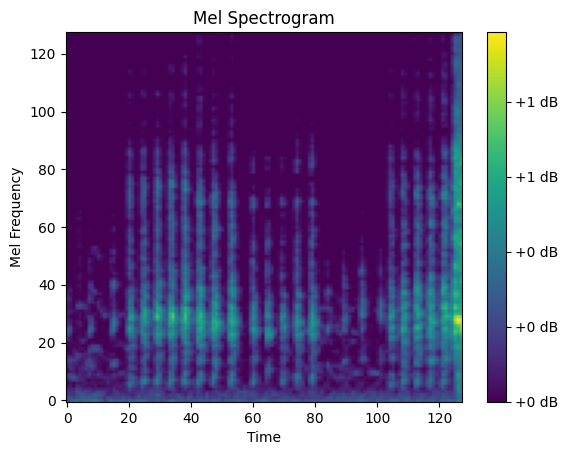

In [15]:
import matplotlib.pyplot as plt

def show_spectrogram(image):
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    
    plt.imshow(image, aspect='auto', origin='lower', cmap='viridis')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.show()
show_spectrogram(X_train[200])

#SECTION 1: Model Architecture:



> <img src="./PoachPatrol.drawio.png" alt="?" style="width:25px"/>




In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, get as get_optimizer

def get_optimizer_by_name(name, learning_rate):
    name = name.lower()
    optimizers = {
        "adam": Adam,
        "rmsprop": RMSprop,
        "sgd": SGD,
        "adamax": Adamax
    }

    if name not in optimizers:
        raise ValueError(f"Unsupported optimizer '{name}'. Choose from: {list(optimizers.keys())}")
    if name == "sgd":
        return optimizers[name](learning_rate=learning_rate, momentum=0.9, nesterov=True)
    return optimizers[name](learning_rate=learning_rate)


def define_model(
                 optimization='adam',
                 regularization_datatype=None,
                 early_stopping=False,
                 dropout=0.3,
                 learning_rate=0.001,
                 input_shape=(128, 128, 1),
                 conv_filters=[32, 64, 128],
                 num_classes=3,
                 patience=5
                 ):

    # Regularization setup
    reg = None
    if regularization_datatype == 'l1':
        reg = regularizers.l1(1e-4)
    elif regularization_datatype == 'l2':
        reg = regularizers.l2(0.01)
    elif regularization_datatype == 'l1_l2':
        reg = regularizers.l1_l2(1e-4)

    # Optimizer setup
    optimizer = get_optimizer_by_name(optimization.lower(), learning_rate)

    # Model architecture
    model = Sequential()

    # Add convolutional layers dynamically
    for idx, filters in enumerate(conv_filters):
        if idx == 0:
            model.add(Conv2D(filters, (3, 3), activation='relu',
                             kernel_regularizer=reg, input_shape=input_shape))
        else:
            model.add(Conv2D(filters, (3, 3), activation='relu',
                             kernel_regularizer=reg))
        model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))

    return model, callbacks

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, classification_report
)
import seaborn as sns


def loss_curve_plot(history):
    """
    Plots the training and validation loss curves from a Keras training history.
    
    Args:
        history: A History object returned by model.fit()
    """
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_classification_model(model, X_test, y_test, class_names=None, show_confusion_matrix=True):
    """
    Evaluates a classification model on test data and prints accuracy, precision, recall, and F1 score.
    
    Parameters:
    - model: Trained Keras model
    - X_test: Scaled test input features
    - y_test: Ground truth labels
    - class_names: List of class names for better report readability
    - show_confusion_matrix: If True, display confusion matrix
    """
    # Predict class probabilities
    y_pred_prob = model.predict(X_test)

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
    average_type = 'weighted'

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average_type)
    precision = precision_score(y_true, y_pred, average=average_type)
    recall = recall_score(y_true, y_pred, average=average_type)

    # Display results
    print("Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    if show_confusion_matrix:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else None,
                    yticklabels=class_names if class_names else None)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

class_labels = list(CLASS_MAPPING.keys())

def train_and_evaluate_model(model, 
                             callbacks=None, 
                             save_path="./saved_model/model_1.keras", 
                             epochs=30, 
                             batch_size=32):
    
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks or [],
    )

    print("\nTraining loss curve")
    loss_curve_plot(history)

    evaluate_classification_model(model, X_test, y_test, class_names=class_labels)
    if len(callbacks) > 0:
        early_stopping = callbacks[0]
        best_epoch = early_stopping.stopped_epoch - early_stopping.patience
        best_val_loss = history.history['val_loss'][best_epoch]
        best_loss = history.history['loss'][best_epoch]

        print(f"Best epoch: {best_epoch + 1}")
        print(f"Training loss at best epoch: {best_loss:.4f}")
        print(f"Validation loss at best epoch: {best_val_loss:.4f}")

    model.save(save_path)
    print(f"\nModel saved to: {save_path}")

    print("✅ Done.")


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

c:\Users\mbric\Documents\Sook\PoachPatrol\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 406ms/step - accuracy: 0.3928 - loss: 1.0810 - val_accuracy: 0.4583 - val_loss: 1.0162
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - accuracy: 0.4872 - loss: 0.9997 - val_accuracy: 0.4881 - val_loss: 1.0588
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.5417 - loss: 0.9630 - val_accuracy: 0.5476 - val_loss: 0.9187
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.5958 - loss: 0.8415 - val_accuracy: 0.6190 - val_loss: 0.8675
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - accuracy: 0.6924 - loss: 0.7443 - val_accuracy: 0.6429 - val_loss: 0.8199
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.7033 - loss: 0.6801 - val_accuracy: 0.6310 - val_loss: 0.8270
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.7492 - loss: 0.6147 - val_accuracy: 0.6786 - val_loss: 0.7918
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.7755 - loss: 0.

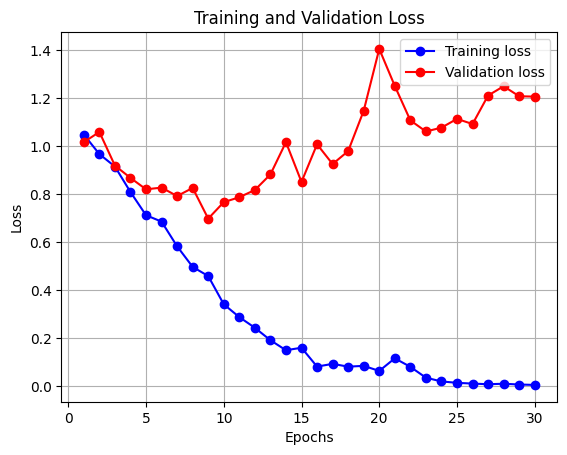

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Evaluation Metrics:
Accuracy : 0.8036
Precision: 0.8033
Recall   : 0.8036
F1 Score : 0.8032

Classification Report:
                precision    recall  f1-score   support

Human Activity       0.79      0.77      0.78        60
 Animal Sounds       0.81      0.85      0.83        66
Ambient Nature       0.80      0.79      0.80        42

      accuracy                           0.80       168
     macro avg       0.80      0.80      0.80       168
  weighted avg       0.80      0.80      0.80       168



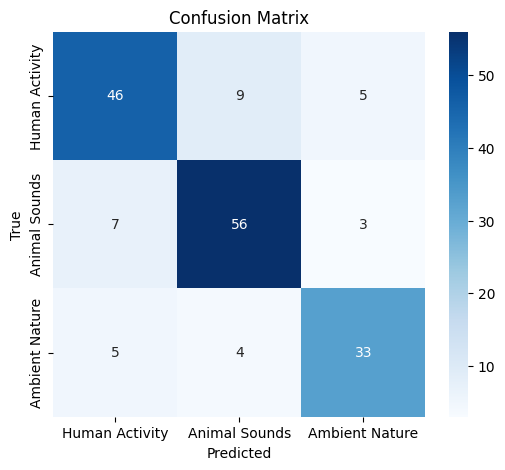


Model saved to: ./saved_model/model_1_unoptimized.keras
✅ Done.


In [32]:
model, callbacks = define_model(dropout=0)
train_and_evaluate_model(model, callbacks=callbacks, save_path="./saved_model/model_1_unoptimized.keras")

Training the model...


c:\Users\mbric\Documents\Sook\PoachPatrol\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.4277 - loss: 3.1550 - val_accuracy: 0.4405 - val_loss: 2.2050
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.4707 - loss: 1.9735 - val_accuracy: 0.4107 - val_loss: 1.6260
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.4567 - loss: 1.5486 - val_accuracy: 0.4881 - val_loss: 1.3888
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.4752 - loss: 1.3468 - val_accuracy: 0.5060 - val_loss: 1.2705
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.5247 - loss: 1.2152 - val_accuracy: 0.4821 - val_loss: 1.1775
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.5598 - loss: 1.1368 - val_accuracy: 0.5000 - val_loss: 1.1583
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.5668 - loss: 1.0900 - val_accuracy: 0.5714 - val_loss: 1.0802
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.5594 - loss: 1.0901 -

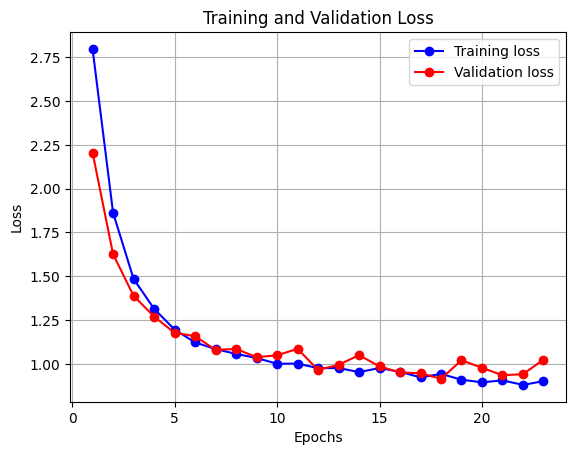

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Evaluation Metrics:
Accuracy : 0.6667
Precision: 0.6847
Recall   : 0.6667
F1 Score : 0.6608

Classification Report:
                precision    recall  f1-score   support

Human Activity       0.72      0.60      0.65        60
 Animal Sounds       0.61      0.83      0.71        66
Ambient Nature       0.75      0.50      0.60        42

      accuracy                           0.67       168
     macro avg       0.69      0.64      0.65       168
  weighted avg       0.68      0.67      0.66       168



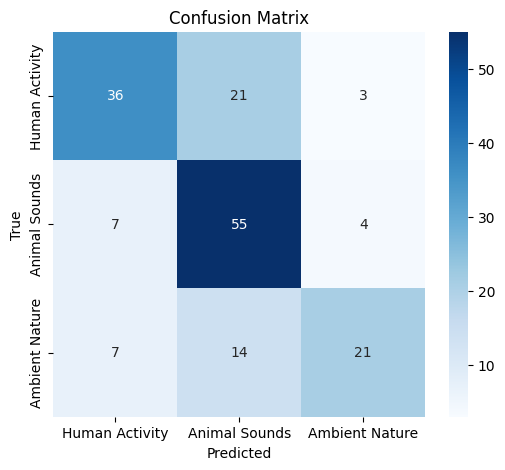

Best epoch: 18
Training loss at best epoch: 0.9430
Validation loss at best epoch: 0.9154

Model saved to: ./saved_model/model_2_RMSprop.keras
✅ Done.


In [33]:
model_2, callbacks = define_model(
    optimization='RMSprop',
    regularization_datatype='l2',
    early_stopping=True,
    dropout=0.4,
    learning_rate=0.0005,
    conv_filters=[32, 64, 128],
)

train_and_evaluate_model(model_2, callbacks=callbacks, epochs=1000, save_path="./saved_model/model_2_RMSprop.keras")

c:\Users\mbric\Documents\Sook\PoachPatrol\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.4281 - loss: 4.0680 - val_accuracy: 0.4524 - val_loss: 1.8443
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.4192 - loss: 1.6328 - val_accuracy: 0.4286 - val_loss: 1.2831
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.4431 - loss: 1.2393 - val_accuracy: 0.4345 - val_loss: 1.1634
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.4920 - loss: 1.1348 - val_accuracy: 0.4881 - val_loss: 1.1290
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.5411 - loss: 1.0707 - val_accuracy: 0.4881 - val_loss: 1.0850
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.5869 - loss: 1.0357 - val_accuracy: 0.4762 - val_loss: 1.0447
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.5600 - loss: 1.0005 - val_accuracy: 0.5595 - val_loss: 1.0084
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0

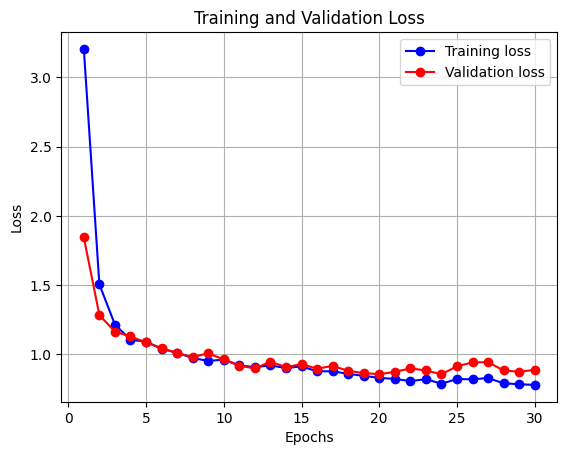

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Evaluation Metrics:
Accuracy : 0.7024
Precision: 0.7107
Recall   : 0.7024
F1 Score : 0.6999

Classification Report:
                precision    recall  f1-score   support

Human Activity       0.72      0.68      0.70        60
 Animal Sounds       0.66      0.80      0.73        66
Ambient Nature       0.77      0.57      0.66        42

      accuracy                           0.70       168
     macro avg       0.72      0.69      0.69       168
  weighted avg       0.71      0.70      0.70       168



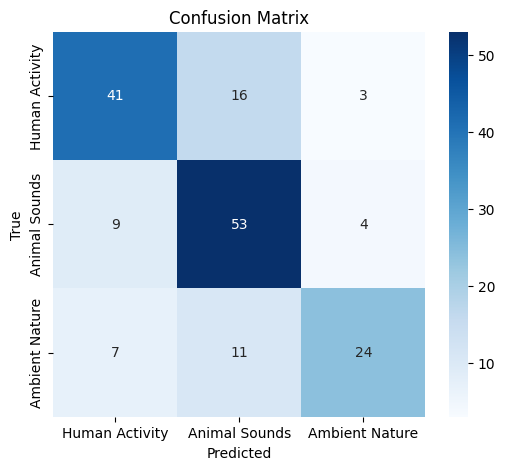

Best epoch: 20
Training loss at best epoch: 0.8295
Validation loss at best epoch: 0.8558

Model saved to: ./saved_model/model_3_Adam.keras
✅ Done.


In [31]:
model_3, callbacks = define_model(
    optimization='Adam',
    regularization_datatype='l2',
    early_stopping=True,
    dropout=0.2,
    learning_rate=0.001,
    conv_filters=[32, 64, 128, 256],
    patience=10
)

train_and_evaluate_model(model_3, callbacks=callbacks, epochs=1000, save_path="./saved_model/model_3_Adam.keras")

c:\Users\mbric\Documents\Sook\PoachPatrol\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.3817 - loss: 2.7497 - val_accuracy: 0.4405 - val_loss: 2.7151
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.3884 - loss: 2.7148 - val_accuracy: 0.4524 - val_loss: 2.6798
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.4578 - loss: 2.6521 - val_accuracy: 0.4524 - val_loss: 2.6495
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.4777 - loss: 2.6251 - val_accuracy: 0.4286 - val_loss: 2.6260
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.4280 - loss: 2.5865 - val_accuracy: 0.4940 - val_loss: 2.5517
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.5208 - loss: 2.5307 - val_accuracy: 0.4762 - val_loss: 2.5063
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.5201 - loss: 2.4873 - val_accuracy: 0.5060 - val_loss: 2.4718
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0

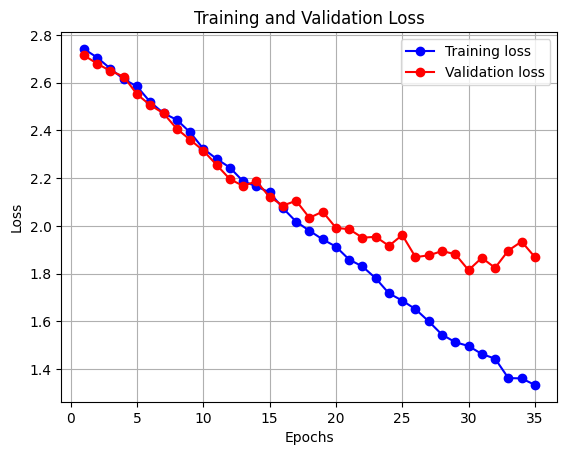

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Evaluation Metrics:
Accuracy : 0.7976
Precision: 0.8076
Recall   : 0.7976
F1 Score : 0.7999

Classification Report:
                precision    recall  f1-score   support

Human Activity       0.85      0.77      0.81        60
 Animal Sounds       0.86      0.82      0.84        66
Ambient Nature       0.67      0.81      0.73        42

      accuracy                           0.80       168
     macro avg       0.79      0.80      0.79       168
  weighted avg       0.81      0.80      0.80       168



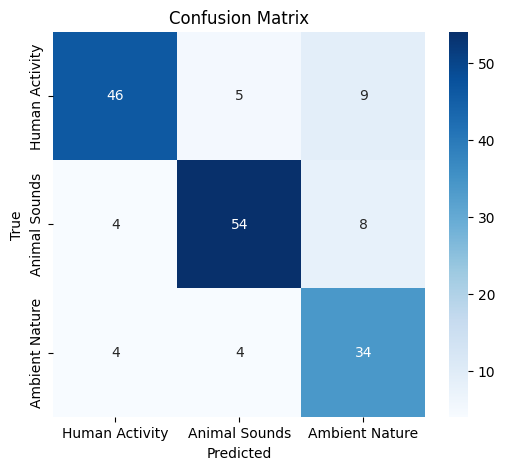

Best epoch: 30
Training loss at best epoch: 1.4965
Validation loss at best epoch: 1.8144

Model saved to: ./saved_model/model_4_SGD.keras
✅ Done.


In [34]:
model_4, callbacks = define_model(
    optimization='sgd',
    regularization_datatype='l1_l2',
    early_stopping=True,
    dropout=0.5,
    learning_rate=0.01,
    conv_filters=[32, 64, 128, 256],
    patience=5
)

train_and_evaluate_model(model_4, callbacks=callbacks, epochs=1000, save_path="./saved_model/model_4_SGD.keras")

Tuning hyperparameters...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Hyperparameters:
max_depth: 20
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 100
Evaluation Metrics:
Accuracy : 0.6905
Precision: 0.7204
Recall   : 0.6905
F1 Score : 0.6873

Classification Report:
                precision    recall  f1-score   support

Human Activity       0.60      0.87      0.71        60
 Animal Sounds       0.81      0.64      0.71        66
Ambient Nature       0.76      0.52      0.62        42

      accuracy                           0.69       168
     macro avg       0.72      0.68      0.68       168
  weighted avg       0.72      0.69      0.69       168



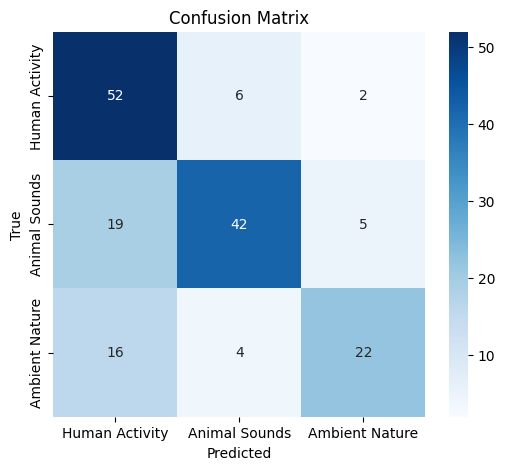


Training Accuracy: 0.9936
Model saved to ./saved_model/model_5_random_forest_model.joblib


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import joblib


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 40, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

print("Tuning hyperparameters...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit([x.flatten() for x in X_train], y_train)
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Evaluate the model
y_pred = best_model.predict([x.flatten() for x in X_test])
evaluate_classification_model(best_model, [x.flatten() for x in X_test], y_test, class_names=class_labels)
y_train_pred = best_model.predict([x.flatten() for x in X_train])
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Save the model
model_filename = './saved_model/model_5_random_forest_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [10]:
import os
import numpy as np
from tensorflow.keras.models import load_model as keras_load_model
import joblib
def make_predictions(model_path, X, return_labels=False):

    _, ext = os.path.splitext(model_path)

    if ext == '.h5' or ext == '.keras':
        model = keras_load_model(model_path)
        probs = model.predict(X)
        predictions = np.argmax(probs, axis=1)
    elif ext == '.pkl' or ext == '.joblib':
        model = joblib.load(model_path)
        predictions = model.predict(X)
    else:
        raise ValueError(f"Unsupported model file extension: {ext}")

    if return_labels:
        LABEL_INDEX_TO_NAME = list(CLASS_MAPPING.keys())
        return [LABEL_INDEX_TO_NAME[p] for p in predictions]

    return predictions

In [16]:
model_path = "./saved_model/model_1_unoptimized.keras"
make_predictions(model_path, np.expand_dims(X_test[1], axis=0), return_labels=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


['Ambient Nature']

Congratulations!!
